# CS542 - Final project, iNaturalist Challenge at FGVC 2017:

The task of your project is an image recognition task similar to this [Kaggle competition](https://www.kaggle.com/c/inaturalist-challenge-at-fgvc-2017/overview).
Why is it challenging? since there are 1010 classes of plants (mostly plants) and only about 250,000 data points.

# Dataset
The dataset is downloaded on scc in the address: "/projectnb2/cs542-bap/classChallenge/data". You can find the python version of this notebook there as well or you could just type "jupyter nbconvert --to script baselineModel.ipynb" and it will output "baselineModel.py". You should be able to run "baselineModel.py" on scc by simply typing "python baselineModel.py"

Please don't change or delete the dataset.

# Evaluation:
You will compete with each other over your performance on the dedicated test set. The performance measure is top the 5 accuracy, i.e: if the true class is in one of your top 5 likely predictions. 

# Baseline:
The following code is a baseline which you can use and improve to come up with your fine-tuned model. Feel free to change anything other than the test split and the  top5 accuracy evaluation at the end.

# Suggestion
One simple suggestion would be to use a pretrained model on imagenet and finetune it on this data similar to this [link](https://keras.io/api/applications/)
Also you should defenitly do much more than 2 epochs.

## Import TensorFlow and other libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset

In [39]:
import pathlib
data_dir = 'data/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images = ",image_count)

Total number of images =  268243


## Here are some images

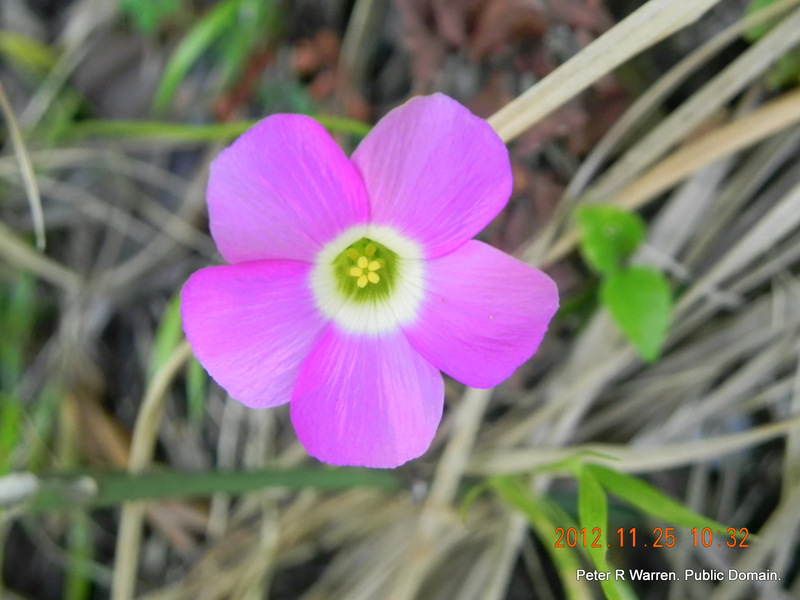

In [40]:
flower = list(data_dir.glob('595/*')) 
PIL.Image.open(str(flower[0]))

# Create a dataset

In [41]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False, seed=tf.constant(0,dtype=tf.int64))

In [42]:
for f in list_ds.take(5):
     print(f.numpy())

b'data/86/7a4c461ea7a87e79d6a80814895da783.jpg'
b'data/476/ab50027577c4bce5c0a38cb0c7bc1091.jpg'
b'data/863/2e0051d16ceb607ad9fe81b0b592eb24.jpg'
b'data/217/cb67ac9a89bab1c61232b92c521df9fd.jpg'
b'data/188/c2db601c27f0b22aa1b434ae3199c165.jpg'


## Infer class names from folders that images reside in

In [43]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
num_classes = class_names.shape[0]

## Split the dataset into train and validation and test:

In [44]:
test_size = int(image_count * 0.15)
test_ds = list_ds.take(test_size)
list_ds = list_ds.skip(test_size)

# Feel free to change anything from bellow this line ----------------------

In [45]:
train_size = int(image_count * 0.7)
train_ds = list_ds.take(train_size)
val_ds = list_ds.skip(train_size)

In [46]:
print("train size = ", tf.data.experimental.cardinality(train_ds).numpy())
print("validation size = ", tf.data.experimental.cardinality(val_ds).numpy())
print("test size = ", tf.data.experimental.cardinality(test_ds).numpy())

train size =  187770
validation size =  40237
test size =  40236


## Write a short function that converts a file path to an (img, label) pair:

In [47]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Image resize settings and batchsize

In [48]:
batch_size = 64
img_height = 180
img_width = 180

In [49]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [50]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  574


## Data loader hyper-parameters for performance!

In [51]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Here are some resized images ready to use!

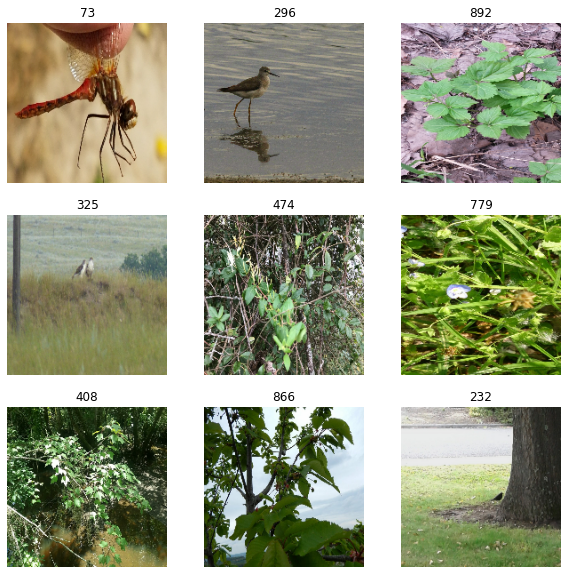

In [52]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## A simple CNN model!

In [53]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, activation='relu'),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

## The usuall loss function

In [54]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

## Training

In [55]:
model.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/2
 865/2934 [=======>......................] - ETA: 1:02:47 - loss: 6.6794 - accuracy: 0.0027 - sparse_top_k_categorical_accuracy: 0.0136

# Evaluate the top k accuracy

# Dont change anything from bellow this line ---------------------------------------

In [ ]:
topKAcc = []
for image_batch, labels_batch in test_ds:
    predicts = model.predict(image_batch)
    one_hot_labels = tf.one_hot(labels_batch, num_classes)

    topKAcc = tf.keras.metrics.top_k_categorical_accuracy(
    one_hot_labels, predicts, k=5)

    topKAcc += [tf.math.reduce_mean(topKAcc).numpy()]

import numpy as np
print("Top K accuracy on test set is = ", np.mean(topKAcc))